# Hand Gesture Test Notebook

This notebook allows you to:
1. Capture a hand image from your webcam (press 's' to save).
2. Detect and display hand landmarks.
3. Extract features from the landmarks.
4. Predict the hand gesture using your trained model.

In [1]:
import cv2

print("Press 's' to save a screenshot, or 'q' to quit.")
cap = cv2.VideoCapture(0)
saved_path = 'hand_test.jpg'
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow('Webcam - Press s to save', frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):
        cv2.imwrite(saved_path, frame)
        print(f"Screenshot saved as {saved_path}")
        break
    elif key == ord('q'):
        print("Quit without saving.")
        break
cap.release()
cv2.destroyAllWindows()

Press 's' to save a screenshot, or 'q' to quit.
Screenshot saved as hand_test.jpg


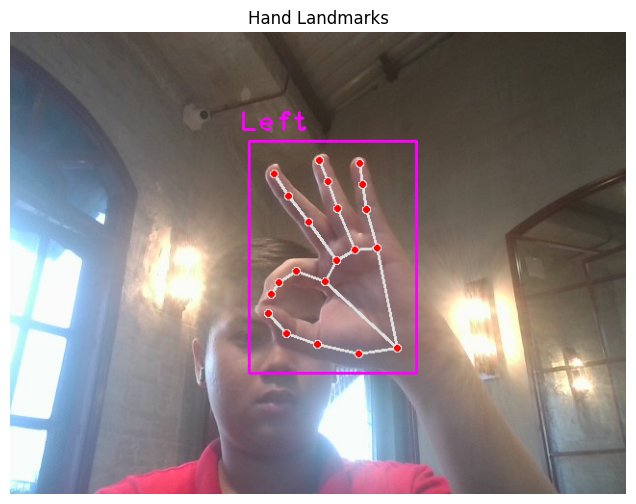

Landmarks: [[402, 328, 0], [362, 334, -13], [319, 324, -21], [287, 313, -30], [268, 292, -38], [327, 259, 0], [297, 248, -22], [279, 260, -40], [271, 272, -50], [339, 237, -3], [310, 197, -15], [289, 170, -23], [274, 147, -28], [358, 226, -11], [340, 183, -24], [330, 155, -29], [321, 133, -30], [381, 224, -20], [370, 184, -30], [366, 158, -31], [363, 136, -29]]


In [2]:
from cvzone.HandTrackingModule import HandDetector
import matplotlib.pyplot as plt
import cv2

# Load the saved image
img_path = 'hand_test.jpg'
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image {img_path} not found. Please run the previous cell to capture an image.")

# Initialize hand detector
hand_detector = HandDetector(detectionCon=0.8, maxHands=1)
hands, img_with_hand = hand_detector.findHands(img.copy())

# Show image with landmarks
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_with_hand, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hand Landmarks')
plt.show()

# Save landmarks for next step
if hands:
    landmarks = hands[0]['lmList']
else:
    landmarks = None
print('Landmarks:', landmarks)

In [6]:
import numpy as np
import math
import pandas as pd

# Show all rows and columns in DataFrame output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def calculate_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 + (point1[2] - point2[2])**2)

def calculate_angle(p1, p2, p3):
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1], p1[2] - p2[2]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1], p3[2] - p2[2]])
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    cos_angle = np.dot(v1, v2) / (norm_v1 * norm_v2)
    cos_angle = np.clip(cos_angle, -1, 1)
    return math.acos(cos_angle)

def extract_features_from_landmarks(landmarks):
    features = []
    wrist = landmarks[0]
    fingertips = [4, 8, 12, 16, 20]
    mcps = [1, 5, 9, 13, 17]
    finger_segments = [
        [1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12],
        [13, 14, 15, 16], [17, 18, 19, 20]
    ]
    for tip_idx in fingertips:
        features.append(calculate_distance(wrist, landmarks[tip_idx]))
    for i in range(len(fingertips)):
        for j in range(i+1, len(fingertips)):
            features.append(calculate_distance(landmarks[fingertips[i]], landmarks[fingertips[j]]))
    for mcp_idx in mcps:
        features.append(calculate_distance(wrist, landmarks[mcp_idx]))
    for finger in finger_segments:
        total_length = 0
        for i in range(len(finger)-1):
            total_length += calculate_distance(landmarks[finger[i]], landmarks[finger[i+1]])
        features.append(total_length)
        for i in range(len(finger)-1):
            features.append(calculate_distance(landmarks[finger[i]], landmarks[finger[i+1]]))
    for finger in finger_segments:
        for i in range(1, len(finger)-1):
            features.append(calculate_angle(landmarks[finger[i-1]], landmarks[finger[i]], landmarks[finger[i+1]]))
    features.append(calculate_angle(landmarks[4], landmarks[0], landmarks[8]))
    features.append(calculate_angle(landmarks[8], landmarks[0], landmarks[12]))
    features.append(calculate_angle(landmarks[12], landmarks[0], landmarks[16]))
    features.append(calculate_angle(landmarks[16], landmarks[0], landmarks[20]))
    palm_points = [0, 1, 5, 9, 13, 17]
    palm_center = np.mean([landmarks[i] for i in palm_points], axis=0)
    for tip_idx in fingertips:
        features.append(calculate_distance(palm_center, landmarks[tip_idx]))
    tip_distances = [calculate_distance(wrist, landmarks[tip_idx]) for tip_idx in fingertips]
    features.append(np.var(tip_distances))
    features.append(np.mean(tip_distances))
    features.append(np.std(tip_distances))
    wrist_to_middle = np.array(landmarks[9]) - np.array(wrist)
    features.append(math.atan2(wrist_to_middle[1], wrist_to_middle[0]))
    features.append(math.atan2(wrist_to_middle[2], math.sqrt(wrist_to_middle[0]**2 + wrist_to_middle[1]**2)))
    max_spread = 0
    for i in range(len(fingertips)):
        for j in range(i+1, len(fingertips)):
            dist = calculate_distance(landmarks[fingertips[i]], landmarks[fingertips[j]])
            max_spread = max(max_spread, dist)
    features.append(max_spread)
    features.append(calculate_distance(landmarks[4], landmarks[20]))
    z_coords = [landmarks[i][2] for i in range(21)]
    features.append(np.mean(z_coords))
    features.append(np.std(z_coords))
    features.append(max(z_coords) - min(z_coords))
    return np.array(features).reshape(1, -1)

if landmarks:
    features = extract_features_from_landmarks(landmarks)
    # Display features as a DataFrame for easier viewing
    if 'feature_names' in globals():
        feats_df = pd.DataFrame(features, columns=feature_names)
        display(feats_df.T.rename(columns={0: 'Value'}))
    else:
        print('Extracted features:', features)
else:
    print('No landmarks detected. Please try again.')

,Value
wrist_to_thumb_tip_distance,143.861044
wrist_to_index_tip_distance,150.986754
wrist_to_middle_tip_distance,223.447981
wrist_to_ring_tip_distance,213.274471
wrist_to_pinky_tip_distance,198.055548
thumb_tip_to_index_tip_distance,23.515952
thumb_tip_to_middle_tip_distance,145.468210
thumb_tip_to_ring_tip_distance,167.791537
thumb_tip_to_pinky_tip_distance,182.871540
index_tip_to_middle_tip_distance,126.956686


In [4]:
import pickle
import pandas as pd

# Load trained model
with open('d:/HAND_GESTURE/trained_models.pkl', 'rb') as f:
    model_data = pickle.load(f)
models = model_data['models']
scaler = model_data['scaler']
label_encoder = model_data['label_encoder']
feature_names = model_data['feature_names']

# Use the best model (SVM preferred)
best_model = models['SVM'] if 'SVM' in models else list(models.values())[0]

if landmarks:
    feats_df = pd.DataFrame(features, columns=feature_names)
    feats_scaled = scaler.transform(feats_df)
    pred = best_model.predict(feats_scaled)[0]
    gesture = label_encoder.classes_[pred]
    print(f'Predicted hand gesture: {gesture}')
else:
    print('No landmarks detected. Cannot predict gesture.')

Predicted hand gesture: ok
